In [1]:
include("src/PyrochloreGeometry.jl")
import .PyrochloreGeometry as geom
# import CSV
using StaticArrays
using LinearAlgebra
using BenchmarkTools
LinearAlgebra.BLAS.set_num_threads(1)

# Vec3_F64 = Union{SVector{Float64,3},Vector{Float64}}
# define static convenience types

const Vec3 = geom.Vec3;
const Vec3_F64 = geom.Vec3_F64;


In [6]:
using JLD
using HDF5
data = load("output/integrated?name=0flux?J_pm=-0.040?B=[0.023,0.023,0.023].jld")

Dict{String, Any} with 3 entries:
  "intensity"              => Dict{String, Any}("Spp"=>ComplexF64[2992.9+825.27…
  "integration_parameters" => Dict{String, Any}("broadening_dE"=>0.02, "n_K_sam…
  "physical_parameters"    => Dict{String, Any}("emergent_fluxes"=>[0.0 0.0 0.0…

In [8]:
data["intensity"]

Dict{String, Any} with 4 entries:
  "Spp"       => ComplexF64[2992.9+825.271im]
  "W"         => [0.0, 0.00909046, 0.0181809, 0.0272714, 0.0363618, 0.0454523, …
  "Spm"       => ComplexF64[3.47544e7-9.7745e-12im]
  "Smagnetic" => [7.81005e6]

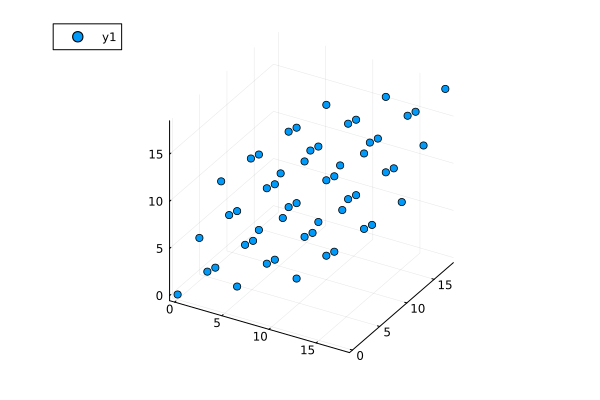

In [4]:
using Plots
lat = geom.PyroPrimitive(3,3,3)
# print(lat.tetra_sites)
X = reduce(hcat, lat.tetra_sites)
scatter(X[1,:],X[2,:], X[3,:])


In [6]:
lat = geom.PyroPrimitive(4,4,5)

# check that these are correct
for (i, ts) in enumerate(lat.tetra_sites)
    x = ts + geom.primitive_basis*([-6,5,-10].*lat.L)
    J = geom.tetra_idx(lat, x)
    if i != J
        println(i," ",x," -> ",J," ", lat.tetra_sites[J] )
    end
end

In [7]:
# check that these are correct
for (i, ts) in enumerate(lat.spin_sites)
    x = ts + geom.primitive_basis*([-6,5,-10].*lat.L)
    J = geom.spin_idx(lat, x)
    if i != J
        println(i," ",x," -> ",J," ", lat.spin_sites[J] )
    end
end

In [8]:
@benchmark geom.tetra_idx(lat, lat.tetra_sites[11])

BenchmarkTools.Trial: 10000 samples with 192 evaluations.
 Range (min … max):  515.406 ns …  14.285 μs  ┊ GC (min … max): 0.00% … 95.44%
 Time  (median):     528.214 ns               ┊ GC (median):    0.00%
 Time  (mean ± σ):   554.277 ns ± 476.996 ns  ┊ GC (mean ± σ):  4.37% ±  4.83%

         ▁▁▆█▇▄▆▅▃▂▅▇█▃▅▁                                        
  ▁▁▁▂▂▄▆████████████████▆▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▃
  515 ns           Histogram: frequency by time          565 ns <

 Memory estimate: 672 bytes, allocs estimate: 17.

In [9]:
@benchmark geom.spin_idx(lat, lat.spin_sites[ 11 ])

BenchmarkTools.Trial: 10000 samples with 60 evaluations.
 Range (min … max):  859.033 ns … 30.530 μs  ┊ GC (min … max): 0.00% … 95.91%
 Time  (median):     872.233 ns              ┊ GC (median):    0.00%
 Time  (mean ± σ):   927.266 ns ±  1.184 μs  ┊ GC (mean ± σ):  5.19% ±  3.94%

     █▇█▂▂                                                      
  ▂▄▇█████▇▄▃▃▃▃▃▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂ ▃
  859 ns          Histogram: frequency by time         1.01 μs <

 Memory estimate: 1.27 KiB, allocs estimate: 35.

In [40]:
# function get_dual_A_fcc_locations(lattice::PyroLattice)
#     locs = []
#     for ix in 0:lattice.L[1]-1, iy in 0:lattice.L[2]-1, iz in 0:lattice.L[3]-1
#         rA = primitive_basis * [ix, iy, iz]
#         push!(locs, rA + [4,4,4])
#     end
        
#     return locs
# end

# function get_hexagons(lattice::PyroLattice)
#     #=
#     Returns a list of n_spin hexagons, in the format of 6-membered lists
#     [[J1, mu1] [J1, nu1] [J2, mu3] .... [J3,nu3]]
#     where the J's are 'A' tetrahedron indices and the mu's are pyrochlore sublattices.
#     =#
#     hexa_sites = [] # index by hexa_sites[dual_fcc_idx][sl] -> 6-member arr
#     for (I, r) in enumerate(get_dual_A_fcc_locations(lattice))
#         row = []
#         for mu in 1:4
#             r_plaq = r + geom.pyro[mu]
#             spin_sites = [r_plaq+y for y in geom.plaqt[mu] ]

#             push!(row, [])
#             for (j, s) in enumerate(spin_sites)
#                 nu = spin_sl(lattice, s)
#                 fcc = s - geom.pyro[nu]
#                 J = tetra_idx(lattice, fcc)
#                 push!(last(row), (J, nu))
#             end
#         end     
#         push!(hexa_sites, row)
#     end
#     return hexa_sites
# end

In [16]:
function calc_fluxes(lattice::geom.PyroPrimitive, A)
    @assert length(A) == length(lattice.spin_sites)
    
    Phi = ones(ComplexF64, length( geom.A_sites(lattice)), 4)
    hexa_sites = geom.get_hexagons(lattice)
    
    for (I, row) in enumerate(hexa_sites)
        for (nu, hex) in enumerate(row)
            for (i, (J, sl)) in enumerate(hex)
                Phi[I,nu] *= exp(1im * A[J, sl] * (-1)^i )
            end
        end
    end
    
    return angle.(Phi)
end

calc_fluxes (generic function with 1 method)

In [17]:
lat = geom.PyroPrimitive(2,1,1)

A = [ 0 0 0 π ; 0 0 0 0]#; 0 0 0 π; 0 0 0 0 ]
calc_fluxes(lat, A)

2×4 Matrix{Float64}:
  3.14159  0.0  -3.14159  0.0
 -3.14159  0.0   3.14159  0.0

In [27]:
# α should be a 3 x 4 matrix such that 
# A_μ (I_i e_i ) = I_i α_iμ
function construct_landau_gauge(lattice::geom.PyroPrimitive, α)
    A_tet_sites = geom.A_sites(lattice)
    
    A = zeros(Float64, length(A_tet_sites),4)
    for (J, tA) in enumerate(A_tet_sites)
        I, _ = geom.tetra_IDX(lattice, tA) # The three-tuple that does the thing
        A[J,:] = I' * α
    end
    # consistency
    println(exp.(1im* lat.L'*α))
    # @assert all(abs.(exp.(1im* lat.L'*α) .- 1.) .< 1e-10)
    return A
end
    

construct_landau_gauge (generic function with 1 method)

In [25]:
lat = geom.PyroPrimitive(8,8,8)


Main.PyrochloreGeometry.PyroPrimitive([8, 8, 8], SVector{3, Int64}[[0, 0, 0], [4, 4, 0], [8, 8, 0], [12, 12, 0], [16, 16, 0], [20, 20, 0], [24, 24, 0], [28, 28, 0], [4, 0, 4], [8, 4, 4]  …  [50, 54, 54], [54, 58, 54], [30, 30, 58], [34, 34, 58], [38, 38, 58], [42, 42, 58], [46, 46, 58], [50, 50, 58], [54, 54, 58], [58, 58, 58]], SVector{3, Int64}[[1, 1, 1], [1, -1, -1], [-1, 1, -1], [-1, -1, 1], [5, 5, 1], [5, 3, -1], [3, 5, -1], [3, 3, 1], [9, 9, 1], [9, 7, -1]  …  [47, 49, 55], [47, 47, 57], [53, 53, 57], [53, 51, 55], [51, 53, 55], [51, 51, 57], [57, 57, 57], [57, 55, 55], [55, 57, 55], [55, 55, 57]])

In [28]:
al1 = [ 0 0 0 0; 0 0 0 0; 0 0 π/4 0]
A = construct_landau_gauge(lat, al1)
calc_fluxes(lat, A)/π

ComplexF64[1.0 - 0.0im 1.0 - 0.0im 1.0 - 2.4492935982947064e-16im 1.0 - 0.0im]


512×4 Matrix{Float64}:
 -0.25  0.25  0.0  0.0
 -0.25  0.25  0.0  0.0
 -0.25  0.25  0.0  0.0
 -0.25  0.25  0.0  0.0
 -0.25  0.25  0.0  0.0
 -0.25  0.25  0.0  0.0
 -0.25  0.25  0.0  0.0
 -0.25  0.25  0.0  0.0
 -0.25  0.25  0.0  0.0
 -0.25  0.25  0.0  0.0
 -0.25  0.25  0.0  0.0
 -0.25  0.25  0.0  0.0
 -0.25  0.25  0.0  0.0
  ⋮                
 -0.25  0.25  0.0  0.0
 -0.25  0.25  0.0  0.0
 -0.25  0.25  0.0  0.0
 -0.25  0.25  0.0  0.0
 -0.25  0.25  0.0  0.0
 -0.25  0.25  0.0  0.0
 -0.25  0.25  0.0  0.0
 -0.25  0.25  0.0  0.0
 -0.25  0.25  0.0  0.0
 -0.25  0.25  0.0  0.0
 -0.25  0.25  0.0  0.0
 -0.25  0.25  0.0  0.0

In [31]:
lat = geom.PyroPrimitive(4,1,4)
# al1 = [ π/2 0 0 -π/2; 0 0 0 0; -π/2 0 0 0]
al1 = [ 0 0 -π/2 π/2; 0 0 0 0; 0 0 π/2 0 ]

A = construct_landau_gauge(lat, al1)
calc_fluxes(lat, A)/π

# [ 1 0 0 0; 0 0 0 0; 0 0 0 0] -> [0 0 -1 1]
# [ 0 1 0 0; 0 0 0 0; 0 0 0 0] -> [0 0 0 0]
# [ 0 0 1 0; 0 0 0 0; 0 0 0 0] -> [1 0 0 -1]
# [ 0 0 0 1; 0 0 0 0; 0 0 0 0] -> [-1 0 1 0]

# [ 0 0 0 0; 1 0 0 0; 0 0 0 0] -> [0 1 0 -1]
# [ 0 0 0 0; 0 1 0 0; 0 0 0 0] -> [-1 0 0 1]
# [ 0 0 0 0; 0 0 1 0; 0 0 0 0] -> [0 0 0 0]
# [ 0 0 0 0; 0 0 0 0; 0 0 0 0] -> [1 -1 0 0]

# [ 0 0 0 0; 0 0 0 0; 1 0 0 0] -> [0 -1 1 0]
# [ 0 0 0 0; 0 0 0 0; 0 1 0 0] -> [1 0 -1 0]
# [ 0 0 0 0; 0 0 0 0; 0 0 1 0] -> [-1 1 0 0]
# [ 0 0 0 0; 0 0 0 0; 0 0 0 1] -> [0 0 0 0]



ComplexF64[1.0 - 0.0im 1.0 - 0.0im 1.0 - 0.0im 1.0 - 2.4492935982947064e-16im]


16×4 Matrix{Float64}:
 0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5

In [4]:
N = 5
println("Unit cell: $(N*N*4*4) primitives")
lat = geom.PyroPrimitive(4*N,1,4*N)
al1 = [ 0 0 -π/2 π/2; 0 0 0 0; 0 0 π/2 0 ]
A = construct_landau_gauge(lat, al1/N)
sum(calc_fluxes(lat, A)/π,dims=1) / size(A)[1]

Unit cell: 400 primitives


LoadError: UndefVarError: `construct_landau_gauge` not defined

In [9]:
using Profile

In [26]:
using Random

In [36]:


function tester(nreps::Int, n_x::Int)
    res = zeros(Float64, n_x)
    tmp = zeros(Float64, n_x)
    for _ = 1:nreps
        rand!(tmp)
        res .+= tmp
    end
    return res
end
        

tester (generic function with 1 method)

In [37]:
@benchmark tester(10, 1000)

BenchmarkTools.Trial: 10000 samples with 3 evaluations.
 Range (min … max):  8.305 μs … 777.695 μs  ┊ GC (min … max): 0.00% … 98.19%
 Time  (median):     9.375 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   9.903 μs ±  17.777 μs  ┊ GC (mean ± σ):  4.37% ±  2.40%

            ▃▇▅█▇▄                                             
  ▆▃▂▁▂▂▂▃▄▆██████▇▆▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂ ▃
  8.31 μs         Histogram: frequency by time          13 μs <

 Memory estimate: 16.00 KiB, allocs estimate: 2.

In [38]:
@benchmark tester(100, 1000)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  79.375 μs …  2.559 ms  ┊ GC (min … max): 0.00% … 96.00%
 Time  (median):     80.625 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   81.439 μs ± 24.951 μs  ┊ GC (mean ± σ):  0.30% ±  0.96%

  ▇▄▄▇█▇▄▁ ▂▂▁▂▃▂▁                                            ▂
  ████████████████▇▇▇█▆▆▇▆▇▅▆▆▆▆▅▅▆▅▅▄▄▆▄▄▄▄▃▄▆▄▃▄▄▄▄▅▅▅▄▄▃▄▄ █
  79.4 μs      Histogram: log(frequency) by time      96.8 μs <

 Memory estimate: 16.00 KiB, allocs estimate: 2.

In [39]:
A = [1., 4., 9.]

3-element Vector{Float64}:
 1.0
 4.0
 9.0

In [42]:
B = [5., 6., 9.]


3-element Vector{Float64}:
 5.0
 6.0
 9.0

In [45]:
A.+=B


3-element Vector{Float64}:
  6.0
 10.0
 18.0

In [46]:
A

3-element Vector{Float64}:
  6.0
 10.0
 18.0